## daily data updates for the helioforecast.space website of science data

Main author: C. Möstl, Austrian Space Weather Office, GeoSphere Austria

https://github.com/cmoestl/heliocats

uses environment 'envs/env_helio4.yml'

need to copy kernel files manually to the kernel paths


In [15]:
# https://github.com/cmoestl/heliocats  data_update_web_science.py

# for updating data every day on the servers

import pickle
import importlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import sys
import numpy as np
import datetime
import scipy.signal
import glob
import urllib
from urllib.request import urlopen
import json
import os   
import time
import h5py
import pytz
import copy
import cdflib
import pandas as pd
from datetime import datetime, timedelta
import spiceypy
import glob
import urllib.request
import json
from bs4 import BeautifulSoup 
import astrospice
from sunpy.coordinates import HeliocentricInertial, HeliographicStonyhurst


from heliocats import data as hd
from heliocats import plot as hp


##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    matplotlib.use('Agg') 
#mac
if sys.platform =='darwin':  
    print('system is mac')
    #for testing
    %matplotlib inline     
    #matplotlib.use('Agg') 



################################################ CHECK  ##############################################
os.system('jupyter nbconvert --to script data_update_web_science.ipynb')   


#import warnings
#warnings.filterwarnings("ignore")

#switches
debug_mode=0


#switches
get_psp=1
get_solo=1

get_wind=1
get_stereoa=1
get_bepi=0
####################################################################################################################


#test execution times
t0all = time.time()

system is mac


[NbConvertApp] Converting notebook data_update_web_science.ipynb to script
[NbConvertApp] Writing 13820 bytes to data_update_web_science.py


### Configure paths depending on server or local machine


In [2]:
if sys.platform == 'linux': 
    
    from config_server import data_path
    from config_server import noaa_path
    from config_server import wind_path
    from config_server import solo_path    
    from config_server import psp_path 
    from config_server import stereoa_path
    from config_server import kernels_path
    from config_server import data_path_ml
    
if sys.platform =='darwin':  

    from config_local import data_path
    from config_local import noaa_path
    from config_local import wind_path
    from config_local import solo_path 
    from config_local import psp_path 
    from config_local import stereoa_path
    from config_local import kernels_path 
    from config_local import data_path_ml

print(' ')
print('------ PATHS ')

print(data_path)
print(noaa_path)
print(wind_path)
print(solo_path)
print(stereoa_path)
print(kernels_path)
#print(data_path_ml)


plot_path=data_path+'plots/'
position_path=data_path+'plots_positions/'
sun_path=data_path+'plots_sun/'

print(plot_path)
print(position_path)



########### make directories first time
if os.path.isdir(plot_path) == False: os.mkdir(plot_path)
if os.path.isdir(plot_path+'omni2') == False: os.mkdir(plot_path+'omni2')
if os.path.isdir(plot_path+'wind') == False: os.mkdir(plot_path+'wind')
if os.path.isdir(plot_path+'solo') == False: os.mkdir(plot_path+'solo')
if os.path.isdir(plot_path+'psp') == False: os.mkdir(plot_path+'psp')
if os.path.isdir(plot_path+'stereoa') == False: os.mkdir(plot_path+'stereoa')
if os.path.isdir(plot_path+'combined') == False: os.mkdir(plot_path+'combined')


if os.path.isdir(position_path) == False: os.mkdir(position_path)
if os.path.isdir(sun_path) == False: os.mkdir(sun_path)
if os.path.isdir(noaa_path) == False: os.mkdir(noaa_path)
if os.path.isdir(solo_path) == False: os.mkdir(solo_path)
if os.path.isdir(solo_path) == False: os.mkdir(psp_path)
if os.path.isdir(data_path_ml) == False: os.mkdir(data_path_ml)

 
------ PATHS 
/Users/chris/python/data/insitu_python/
/Users/chris/python/ops/data/noaa/
/Users/chris/python/data/wind/
/Users/chris/python/data/solo/
/Users/chris/python/data/stereoa/
/Users/chris/python/data/kernels/
/Users/chris/python/data/insitu_python/plots/
/Users/chris/python/data/insitu_python/plots_positions/


### Parker Solar Probe


In [3]:
print(' ')


####### -------- control parameter    
#server
start_time= datetime(2018,10,1)
#end_time= datetime(2018,10,10)
#start_time= datetime(2022,12,1)
end_time = datetime.utcnow() 
psp_file=data_path+'psp_2018_now_rtn.p'


if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

    start_time= datetime(2018,10,5)
    end_time  = datetime(2018,10,7)
    psp_file=data_path+'psp_rtn_test.p'

    
if get_psp > 0:    

    t0 = time.time()  

    print('--------------------- PSP ------------------------- ')
    print('download PSP data until today ')
    print(psp_path)

    hd.download_pspmag_1min(start_time,end_time,psp_path)
    hd.download_pspplas(start_time,end_time,psp_path)

    print('process PSP to pickle')
    hd.create_psp_pkl(start_time,end_time,psp_file,psp_path)
    #print(psph)

    t1=time.time()
    
    print(' ')
    print('PSP done in ', np.round((t1-t0)/60,2), 'minutes')
    print('----------------------------------- ')
    
    
    
    
else:
    print('PSP data NOT downloaded and pickled, turn on switch')  


  

PSP data NOT downloaded and pickled, turn on switch


In [4]:
if get_psp > 0:   
    
    ### data checks

    filepsp='psp_2018_now_rtn.p'
    if debug_mode > 0: filepsp='psp_rtn_test.p'
    [data,header]=pickle.load(open(data_path+filepsp, "rb" ) )

    ############ print header

    print(header)

    ########## add overview plots

    hp.data_overview_plot(data,plot_path+'psp/'+filepsp[:-2])



### Solar Orbiter

In [5]:
print(' ')

####### -------- control parameter    

#for server
start_time= datetime(2020,4,14)
#end_time  = datetime(2020,4,20)
end_time = datetime.utcnow() 
solo_file=data_path+'solo_2020_now_rtn.p'

#testing
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 
    start_time= datetime(2022,1,25)
    end_time  = datetime(2022,2,10)
    solo_file=data_path+'solo_rtn_test.p'


if get_solo > 0:    

    t0 = time.time()  

    print('--------------------- SolO ------------------------- ')
    print('download SolO science data until today ')
    print(solo_path)

    hd.download_solomag_1min(start_time,end_time,solo_path)
    hd.download_soloplas(start_time,end_time,solo_path)

    print('process Solar Orbiter to pickle')
    hd.create_solo_pkl(start_time,end_time,solo_file,solo_path,kernels_path)
    #print(psph)

    t1=time.time()
    
    print(' ')
    print('Solo done in ', np.round((t1-t0)/60,2), 'minutes')
    print('----------------------------------- ')
else:
    print('Solo data NOT downloaded and pickled, turn on switch')  


Solo data NOT downloaded and pickled, turn on switch


In [6]:
if get_solo > 0:  
    
    ### data checks

    filesolo='solo_2020_now_rtn.p'   

    if debug_mode > 0: filesolo='solo_rtn_test.p'

    [data,header]=pickle.load(open(data_path+filesolo, "rb"))
    ############ print header

    print(header)

    ########## add overview plots

    hp.data_overview_plot(data,plot_path+'solo/'+filesolo[:-2])


### Wind 

In [7]:
print(' ')
#for server
start_time= datetime(1995,1,1)
#end_time  = datetime(2020,4,20)
end_time = datetime.utcnow() 
wind_file=data_path+'wind_1995_now_gse.p'

#testing
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 
    start_time= datetime(2022,1,25)
    end_time  = datetime(2022,2,10)
    wind_file=data_path+'wind_gse_test.p'

 

#download data for current year only    
if get_wind > 0:
 
    
    print('-------------------------------- Wind -------------------------- ')
    print('download Wind data ')

    t0 = time.time() 
    
    hd.wind_download_ascii(start_year=datetime.utcnow().year, wind_path=wind_path) 

    t1=time.time()
    
    print('Wind pickle TBD')
    
    print(' ')
    print('Wind done in ', np.round((t1-t0)/60,2), 'minutes')
    print('----------------------------------- ')
    
else:
    print('Wind data NOT downloaded, turn on switch')  
    

#data checks
if get_wind > 0:  

    filewind='wind_1995_now_gse.p'   

    if debug_mode > 0: filewind='wind_gse_test.p'

    #[data,header]=pickle.load(open(data_path+filewind, "rb"))
    ############ print header

    #print(header)

    ########## add overview plots

    #hp.data_overview_plot(data,plot_path+'solo/'+filewind[:-2])


-------------------------------- Wind -------------------------- 
download Wind data 
Wind data NOT downloaded, turn on switch


In [8]:
#filewin="wind_2018_now_heeq.p" 
#start=datetime.datetime(2022, 12, 1)
#start=datetime.datetime(2022, 12, 1)
#end=datetime.datetime.utcnow()

#hd.save_wind_data_ascii(data_path,filewin,start,end,coord='HEEQ')
#[win,winh]=pickle.load(open(data_path+filewin, "rb"))
#start=win.time[-1]-datetime.timedelta(days=365)
#end=datetime.datetime.utcnow()         
#hp.plot_insitu_update(win, start, end,'Wind',plot_path+'wind/',now=True)


#on linux
#print('download new Wind data files without overwriting existing files')

#on mac for testing
#wind_data_path='/Users/chris/python/data/wind/wind_mfi_k0'
#os.system('curl -nc --directory-prefix='+wind_data_path+' "ftps://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_k0/2020/*.cdf"')



#wind_data_path='/perm/aswo/data/wind/wind_mfi_k0'
#print(wind_data_path)
#os.system('wget -nc --directory-prefix='+wind_data_path+' "ftps://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_k0/2020/*.cdf"')
#wind_data_path='/nas/helio/data/heliosat/data/wind_swe_h1'
#os.system('wget -nc --directory-prefix='+wind_data_path+' "ftps://spdf.gsfc.nasa.gov/pub/data/wind/swe/swe_h1/2020/*.cdf"')

#filewin="wind_2018_now_gse.p" 
##xstart=datetime.datetime(2018, 1, 1)
#end=datetime.datetime.utcnow()
#if get_new_data: hd.save_wind_data(data_path,filewin,start,end,heeq=False)
#[win,hwin]=pickle.load(open(data_path+filewin, "rb" ) )  

#filewin="wind_2018_now_heeq.p" 
#start=datetime.datetime(2018, 1, 1)
#end=datetime.datetime.utcnow()
#if get_new_data: hd.save_wind_data(data_path,filewin,start,end,heeq=True)

#start=win.time[-1]-datetime.timedelta(days=100)
#end=datetime.datetime.utcnow()         
#hp.plot_insitu_update(win, start, end,'Wind',plot_path,now=True)

### BepiColombo

In [14]:
print(' ')



####### -------- control parameter    
#server
#start_time= datetime(2018,12,1)
#end_time = datetime.utcnow().date() + timedelta(days=1)
#psp_file=data_path+'psp_2018_now_rtn.p'


if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

    #testing
    start_time= datetime(2021,12,1)
    end_time  = datetime(2021,12,5)
    bepi_file=data_path+'bepi_rtn_test.p'

if get_bepi > 0:    

    t0 = time.time()  

    print('--------------------- Bepi ------------------------- ')
    print('download Bepi data manually ')
    print(bepi_path)

    print('process Bepi Orbiter to pickle')
    #hd.create_solo_pkl(start_time,end_time,solo_file,solo_path,kernels_path)
    #print(psph)

    t1=time.time()
    
    print(' ')
    print('Bepi done in ', np.round((t1-t0)/60,2), 'minutes')
    print('----------------------------------- ')
else:
    print('Bepi data NOT downloaded and pickled, turn on switch')  

#solo=pickle.load(open(data_path+'solo_rtn_test.p', "rb"))
#plt.plot(solo.time,solo.bt)


 
Bepi data NOT downloaded and pickled, turn on switch


### STEREO-A science data

In [9]:

print(' ')

####### control parameter    

#for server
#start_time= datetime(2007,1,1)
start_time= datetime(2017,4,1)
end_time = datetime.utcnow() 

#sta_file=data_path+'stereoa_2007_now_rtn.p'
sta_file=data_path+'stereoa_2017_now_rtn.p'



#testing
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 
    start_time= datetime(2021,4,1)
    end_time  = datetime(2022,12,31)
    sta_file=data_path+'stereoa_rtn_test.p'

    
if get_stereoa > 0:   

    t0 = time.time()  

    print(' ')
    print('------ STEREO-A science data  ------------------')

    print('download STEREO-A science data until today ')
    print(stereoa_path)

    hd.download_stereoa_merged(start_time,end_time,stereoa_path)    

    print('process STEREO-A to pickle')

    hd.create_stereoa_pkl(start_time,end_time,sta_file,stereoa_path)
    
    t1 = time.time()  

    print(' ')
    print('------ STEREO-A done in ', np.round((t1-t0)/60,2), 'minutes')  


else:
    print('STEREO-A data NOT downloaded and pickled, turn on switch')  



 
------ STEREO-A science data  ------------------
download STEREO-A science data until today 
/Users/chris/python/data/stereoa/
sta_l2_magplasma_1m_20170101_v01.cdf has already been downloaded.
sta_l2_magplasma_1m_20180101_v01.cdf has already been downloaded.
Successfully downloaded sta_l2_magplasma_1m_20190101_v01.cdf
sta_l2_magplasma_1m_20200101_v06.cdf has already been downloaded.
sta_l2_magplasma_1m_20210101_v06.cdf has already been downloaded.
sta_l2_magplasma_1m_20220101_v03.cdf has already been downloaded.
ERROR HTTP Error 404: Not Found .File for 2023 does not exist.
process STEREO-A to pickle
/Users/chris/python/data/stereoa/impact/merged/level2/sta_l2_magplasma_1m_20170101_v01.cdf
/Users/chris/python/data/stereoa/impact/merged/level2/sta_l2_magplasma_1m_20180101_v01.cdf
/Users/chris/python/data/stereoa/impact/merged/level2/sta_l2_magplasma_1m_20190101_v01.cdf
/Users/chris/python/data/stereoa/impact/merged/level2/sta_l2_magplasma_1m_20200101_v06.cdf
/Users/chris/python/data/s

/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


ERROR: list index out of range 20230101 does not exist


Files Downloaded: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44file/s]


 
------ STEREO-A done in  5.71 minutes


Science level 2 solar wind magnetic field and plasma data (IMPACT) from STEREO A, obtained from https://spdf.gsfc.nasa.gov/pub/data/stereo/ahead/l2/impact/magplasma/1min/ Timerange: 2017-Apr-01 00:00 to 2022-Dec-31 23:54, with a time resolution of 1 min. The data are available in a numpy recarray, fields can be accessed by stereoa.time, stereoa.bx, stereoa.vt etc. Total number of data points: 2812795. Units are btxyz [nT, RTN], vtxy  [km s^-1], np[cm^-3], tp [K], heliospheric position x/y/z [km], r/lon/lat [AU, degree, HEEQ]. Made with heliocats/data_update_web_science.ipynb by E. Davies (twitter @spacedavies) and C. Möstl (@chrisoutofspace). File creation date: 2023-Jul-28 12:48 UTC


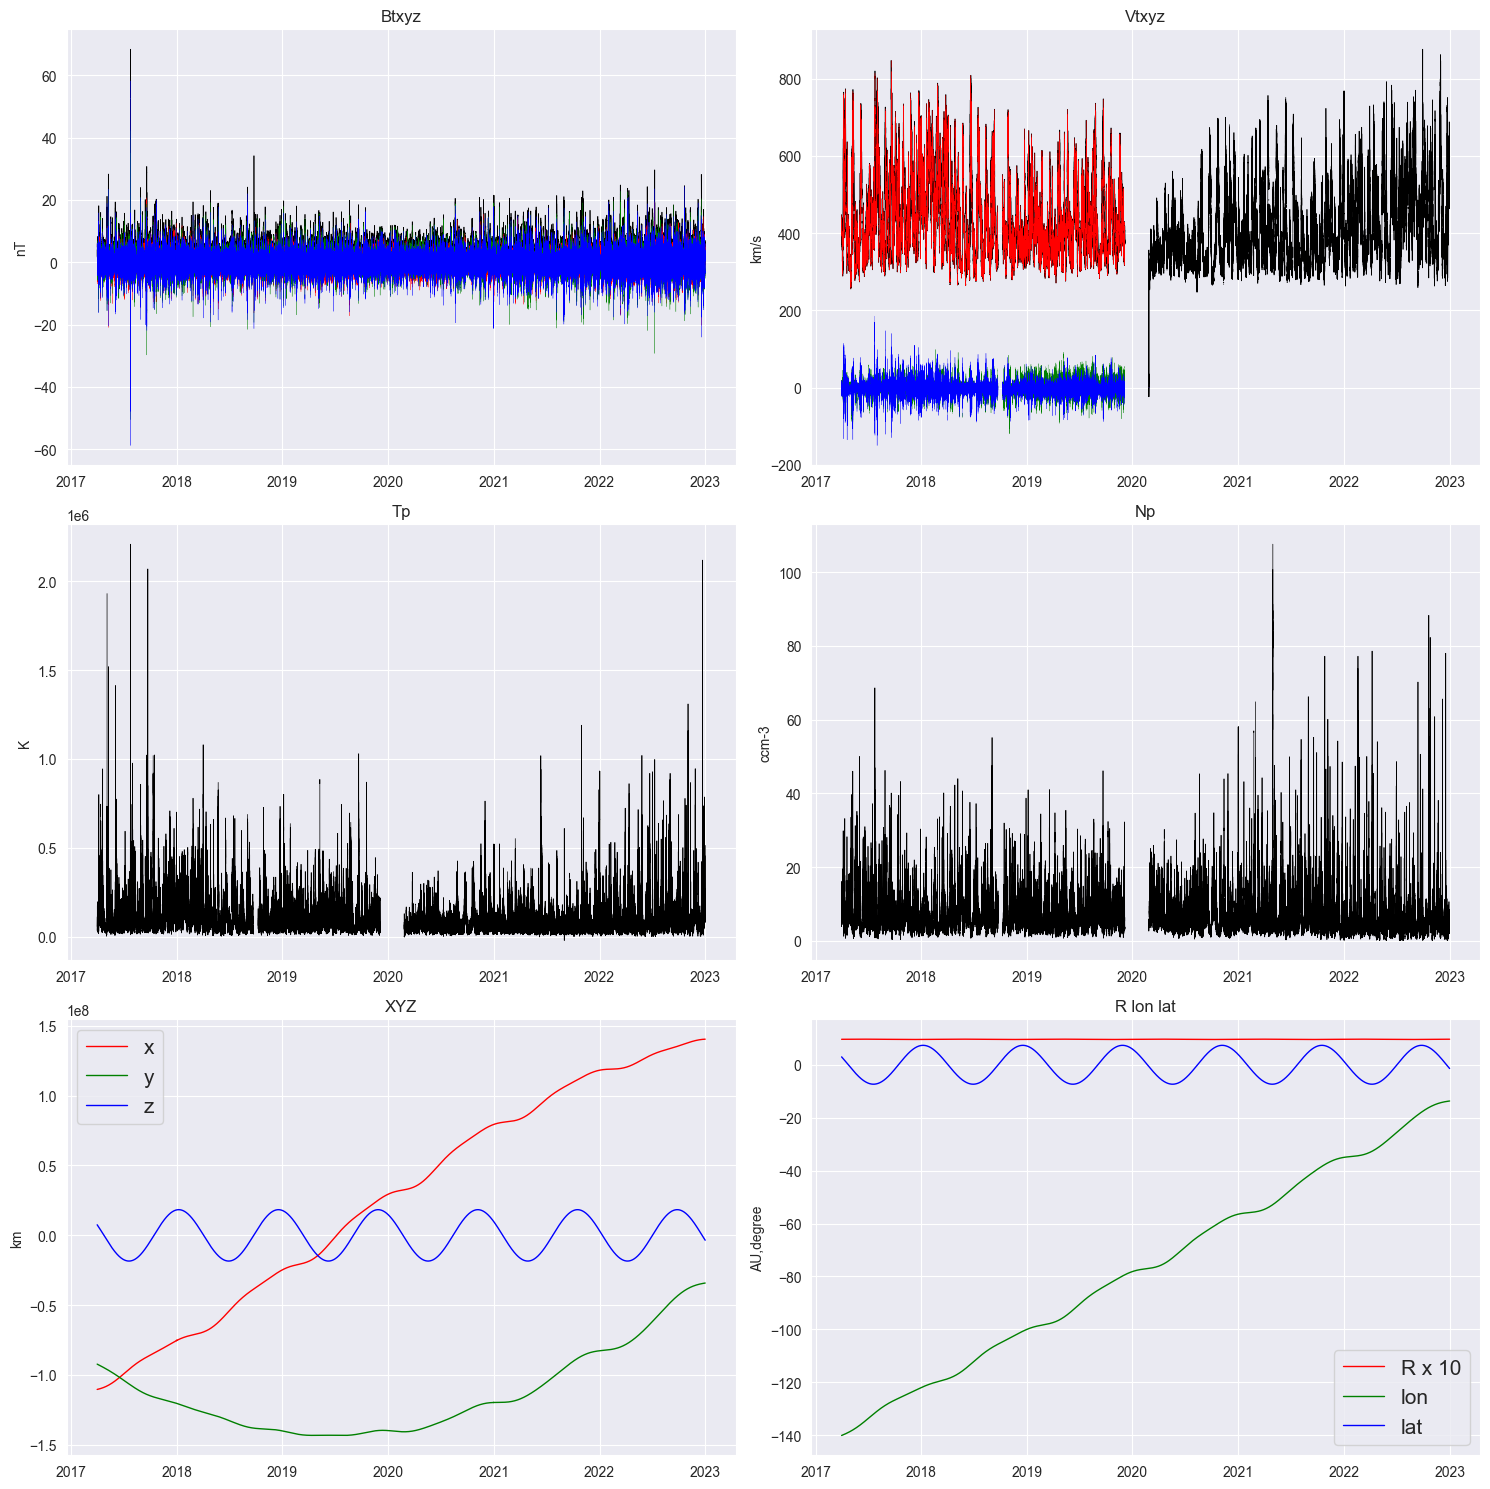

In [12]:

if get_stereoa > 0:  
    
    ### data checks

    #filesta='stereoa_2007_now_rtn.p'   
    filesta='stereoa_2017_now_rtn.p'   

    if debug_mode > 0: 
        importlib.reload(hd) 
        importlib.reload(hp) 
        filesta='stereoa_rtn_test.p'

    [data,header]=pickle.load(open(data_path+filesta, "rb"))
    ############ print header

    print(header)

    ########## add overview plots

    hp.data_overview_plot(data,plot_path+'stereoa/'+filesta[:-2])


In [ ]:
t1all = time.time()

print(' ')
print(' ')
print(' ')
print('------------------')
print('Runtime for full science data update:', np.round((t1all-t0all)/60,2), 'minutes')
print('--------------------------------------------------------------------------------------')


In [10]:


############### write header file for daily updates
#text = open('/nas/helio/data/insitu_python/data_update_headers.txt', 'w')
#text.write('Contains headers for the data files which are updated in real time.'+'\n \n')
#text.write('File creation date:  '+datetime.datetime.utcnow().strftime("%Y-%b-%d %H:%M") +' \n \n')


#text.write('NOAA real time solar wind: '+filenoaa+'\n \n'+ hnoaa+' \n \n')
#text.write('load with: >> [noaa,hnoaa]=pickle.load(open("'+data_path+filenoaa+'", "rb"))') 
#text.write(' \n \n \n \n')

#text.write('STEREO-A beacon: '+filesta_sceq+'\n \n'+ hsta+' \n \n')
#text.write('load with: >> [sta,hsta]=pickle.load(open("'+data_path+filesta+'", "rb"))') 
#text.write(' \n \n \n \n')

#text.write('Wind: '+filewin+'\n \n'+ hwin+' \n \n')
#text.write('load with: >> [win,hwin]=pickle.load(open("'+data_path+filewin+'", "rb" ))') 
#text.write(' \n \n \n \n')


#text.write('OMNI2: '+fileomni+'\n \n'+ ho+' \n \n')
#text.write('load with: >> [o,ho]=pickle.load(open("'+data_path+fileomni+'", "rb" ))') 
#text.write(' \n \n \n \n')

#text.close()